# **Project 2**, APS1070 Fall 2021
**Anomaly Detection Algorithm using Gaussian Mixture Model [13 Marks]**

**Deadline: OCT 22, 9 PM**

**Academic Integrity**

This project is individual - it is to be completed on your own. If you have questions, please post your query in the APS1070 Piazza Q&A forums (the answer might be useful to others!).

Do not share your code with others, or post your work online. Do not submit code that you have not written yourself. Students suspected of plagiarism on a project, midterm or exam will be referred to the department for formal discipline for breaches of the Student Code of Conduct.

Please fill out the following:


*   Name: Juliano Zhu
*   Student Number: 1003976502

##**Part 1: Getting started [1.5 Marks]**

We are going to work with a credit card fraud dataset. This dataset contains 28 key features, which are not 
directly interpretable but contain meaningful information about the dataset.

Load the dataset in CSV file using Pandas. The dataset is called `creditcard.csv`. Print out the first few columns of the dataset.

* How many rows are there? __284807__ **[0.1]**
* What features in the dataset are present aside from the 28 main features?  __Time, Class, Amount__ **[0.1]**
* Which column contains the targets? **Class** **[0.1]**
* To what do the target values correspond? __1 in case of fraud and 0 otherwise__ **[0.1]**

In [1]:
pip install wget

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9672 sha256=431d8865ea7aca38e8c226e2ea8c9ef639683d26648f0e563773924d3e74f335
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [2]:
import wget

wget.download('https://github.com/aps1070-2019/datasets/raw/master/creditcard.tar.gz','creditcard.tar.gz')

'creditcard.tar.gz'

In [3]:
!tar -zxvf creditcard.tar.gz

creditcard.csv


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
df = pd.read_csv('creditcard.csv')

In [5]:
print('Number of row:', len(df))
print(df.columns.values[0], df.columns.values[-1], df.columns.values[-2])


Number of row: 284807
Time Class Amount



* What is the percentage of entries in the dataset for each class? __Class 1 is: 0.1727485630620034 %, Class 0 is: 99.827251436938 %__ **[0.1]**
* Is this data considered balanced or unbalanced? Why is this the case? __Extremely unbalanced, since class 0 has significantly large sample size compared to calss 1__ **[0.1]**
* Why is balance/imbalance important? How might this class ditribution affect a KNN classifier for example, which we explored in Project 1? **Model will have a bias towards predicting the larger classes and may ignore the smaller classes. As a result, the smaller classes are typically misclassified ** **[0.2]**



In [6]:
num_0 = df.groupby('Class').count().values[0,0]
num_1 = df.groupby('Class').count().values[1,0]
print('Class 1 is:', 100*num_1/(num_0+num_1), '%')
print('Class 0 is:', 100*num_0/(num_0+num_1), '%')


Class 1 is: 0.1727485630620034 %
Class 0 is: 99.827251436938 %


In [7]:
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


Next, split the dataset into a training (70%), validation (15%) and testing set (15%). Set the random state to 0. **[0.2]**

Make sure to separate out the column corresponding to the targets.

In [8]:
### Split the data  ###
X = df.drop(['Class'], axis=1)
y = df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size= 15/(15+70), random_state=0)


Now, let's take a look at the difference in distribution for some variables between fraudulent and non-fraudulent transactions:

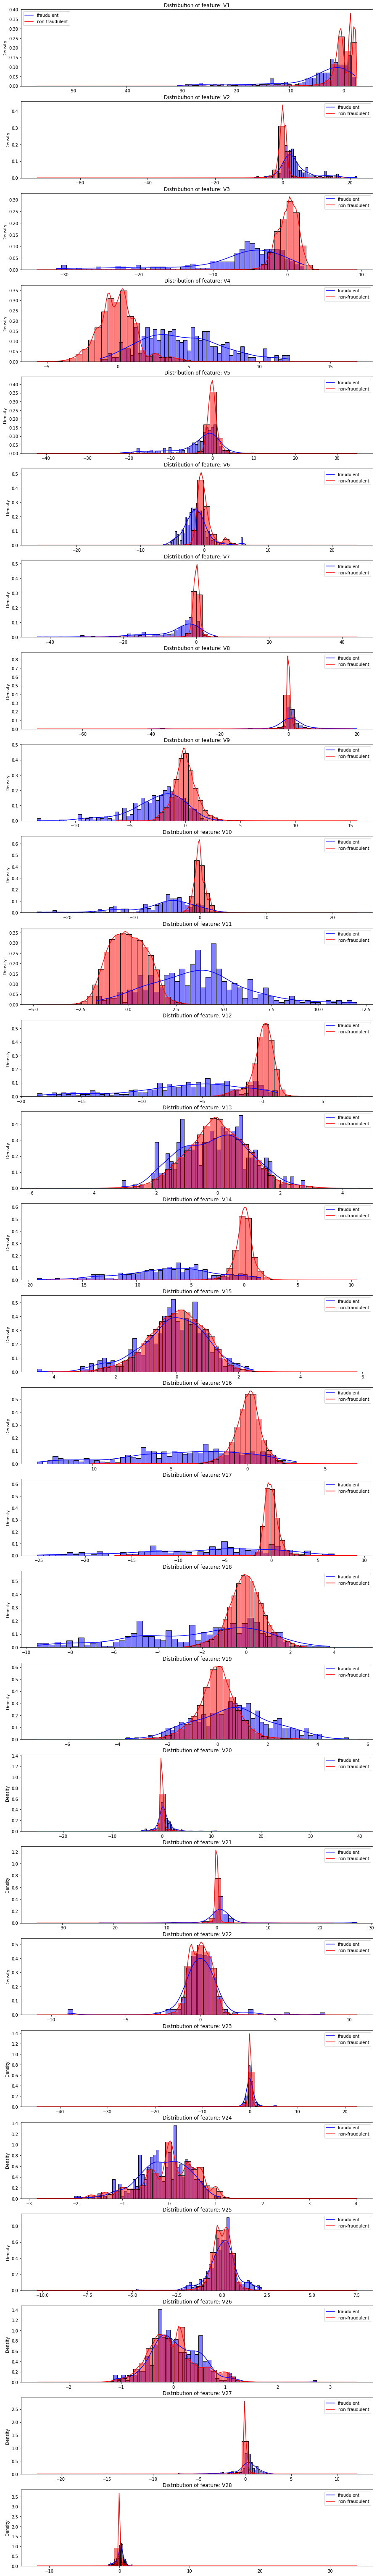

In [ ]:
import matplotlib.gridspec as gridspec
features=[f for f in df.columns if 'V' in f]
nplots=np.size(features)
plt.figure(figsize=(15,4*nplots))
gs = gridspec.GridSpec(nplots,1)
for i, feat in enumerate(features):
    ax = plt.subplot(gs[i])
    sns.histplot(X_train[feat][y_train==1], stat="density", kde=True, color="blue", bins=50)
    sns.histplot(X_train[feat][y_train==0], stat="density", kde=True, color="red", bins=50)
    ax.legend(['fraudulent', 'non-fraudulent'],loc='best')
    ax.set_xlabel('')
    ax.set_title('Distribution of feature: ' + feat)

Explain how these graphs could provide meaningful information about anomaly detection using a gaussian model. **[0.5]**

According to different classes, the fraudulent data is the statistically different from the rest of the observations. If for a particular cluster, if the probability is very low that’s an indication of the data point being an anomaly. For example V3, V4, V9, V10, V11, V12, V14, V16, V17 are useful features, the distributions are separate away from each other - easily distinguished. But for V8, V13, V15, V22, V24, V25, V26 the distributions  are closed to each other, the classes are hard to distinguish and predict.

## **Part 2: Single feature model with one Gaussian distribution: [2.5 Marks]**
We'll start by making a prediction using **a single feature of our dataset at a time**. 

Please note that we **only use `V` features** in our model.

**a. Fitting regardless of class:**
  1. Fit a single Gaussian distribution on a single feature of **the full training dataset** (both classes) using ``sklearn.mixture.GaussianMixture`` when ``n_components=1``. 
  2. Compute AUC (Area under the ROC Curve) based on ``sklearn.mixture.GaussianMixture.score_samples`` on both the full training set and validation set (including both classes).  
  3. Repeat the above steps for each of the features and present your findings in a table. 
  4. Find the best 3 features to distinguish fraudulent transactions from non-fraudulent transactions based on the AUC of the validation set. **[0.2]**
  5. Make a prediction based on a model's scores: If the `score_samples` is lower than a threshold, we consider that transaction as a fraud. Find an optimal threshold that maximizes the F1 Score of the validation set for each of those 3 features separately. (Do not check every possible value for threshold, come up with a faster way!) Compute F1 score using `sklearn.metrics.f1_score`. **[0.5]**
  6. Report the complexity of your method (Big O notation) for determining the optimal threshold.**[0.5]**

**b. Fitting based on class:**
 1. Pick 3 features that had the best AUC in Part 2a. 
 2. Compute AUC and F1 score when you fit a Gaussian **only on non-fraudulent transactions** (instead of all the transactions).
 3. Compare your results from parts 2a and 2b (AUC and F1 score) in a table. **[0.8]**
 4. Are these results different or similar? Why?**[0.5]**





In [ ]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import roc_curve
from sklearn.metrics import auc


X = df.drop(['Class','Time','Amount'], axis=1)
y = df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size= 15/(15+70), random_state=0)

AUC_train = []
AUC_val = []

for i in range(28):
    gm = GaussianMixture(n_components = 1, covariance_type = 'full', random_state=0)
    train_V = X_train.iloc[:, i].values.reshape(-1,1)
    val_V = X_val.iloc[:, i].values.reshape(-1,1)
    gm.fit(train_V)
    p_gm = gm.score_samples(train_V)
    p_gm_val = gm.score_samples(val_V)
    fpr_gm, tpr_gm, _ = roc_curve(y_train, 1-p_gm)
    fpr_gm_val, tpr_gm_val, _ = roc_curve(y_val, 1-p_gm_val)
    area_train = auc(fpr_gm, tpr_gm)
    area_val = auc(fpr_gm_val, tpr_gm_val)

    AUC_train.append(area_train)
    AUC_val.append(area_val)


In [ ]:
table = pd.DataFrame({'feature': X_train.columns, 'Train AUC': AUC_train, 'Val AUC': AUC_val})
table.sort_values(by=['Val AUC'])
#top 3: V14, V12, V17

,feature,Train AUC,Val AUC
14,V15,0.526280,0.449022
23,V24,0.479669,0.455708
25,V26,0.498072,0.547121
24,V25,0.578081,0.555059
21,V22,0.548228,0.582029
12,V13,0.560512,0.603536
18,V19,0.741973,0.716805
5,V6,0.734653,0.721507
22,V23,0.691576,0.723037
19,V20,0.736304,0.724534


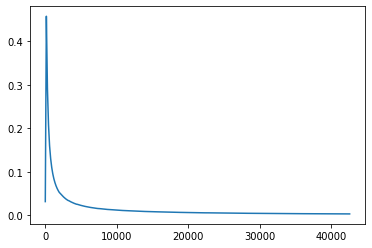

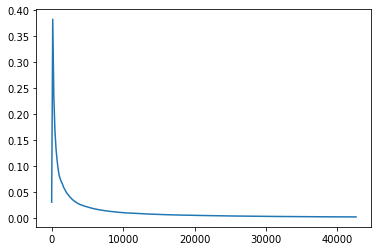

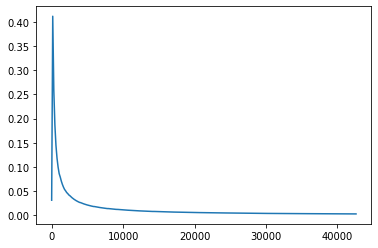

In [ ]:
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

for f in ['V14', 'V12', 'V17']:
    F1_list = []
    i_list = []
    gm = GaussianMixture(n_components = 1, covariance_type = 'full', random_state=0)
    train_V = X_train[f].values.reshape(-1,1)
    val_V = X_val[f].values.reshape(-1,1)
    gm.fit(train_V)
    p_gm = gm.score_samples(val_V)
    for i in range(1, len(X_val), 150):
        threshold = sorted(p_gm)[i]
        F1 = f1_score(y_val, p_gm < threshold)
        F1_list.append(F1)
        i_list.append(i)
    plot = plt.figure()
    plt.plot(i_list, F1_list)

In [ ]:
#It seems the best F1 occur at 0~1000

V14_F1_list = []
V12_F1_list = []
V17_F1_list = []

#V14
gm = GaussianMixture(n_components = 1, covariance_type = 'full', random_state=0)
gm.fit(X_train['V14'].values.reshape(-1,1))
V14_p_gm = gm.score_samples(X_val['V14'].values.reshape(-1,1))
for i in range(1, 1000):
    threshold = sorted(V14_p_gm)[i]
    F1 = f1_score(y_val, V14_p_gm < threshold)
    V14_F1_list.append(F1)
print("V14 Highest F1 is:", max(V14_F1_list))
print("V14 threshold is:", V14_p_gm[np.array(V14_F1_list).argmax()])

#V12
gm = GaussianMixture(n_components = 1, covariance_type = 'full', random_state=0)
gm.fit(X_train['V12'].values.reshape(-1,1))
V12_p_gm = gm.score_samples(X_val['V12'].values.reshape(-1,1))
for i in range(1, 1000):
    threshold = sorted(V12_p_gm)[i]
    F1 = f1_score(y_val, V12_p_gm < threshold)
    V12_F1_list.append(F1)
print("V12 Highest F1 is:", max(V12_F1_list))
print("V12 threshold is:", V12_p_gm[np.array(V12_F1_list).argmax()])

#V17
gm = GaussianMixture(n_components = 1, covariance_type = 'full', random_state=0)
gm.fit(X_train['V17'].values.reshape(-1,1))
V17_p_gm = gm.score_samples(X_val['V17'].values.reshape(-1,1))
for i in range(1, 1000):
    threshold = sorted(V17_p_gm)[i]
    F1 = f1_score(y_val, V17_p_gm < threshold)
    V17_F1_list.append(F1)
print("V17 Highest F1 is:", max(V17_F1_list))
print("V17 threshold is:", V17_p_gm[np.array(V17_F1_list).argmax()])


V14 Highest F1 is: 0.6218487394957983
V14 threshold is: -1.2604789736516193
V12 Highest F1 is: 0.6285714285714286
V12 threshold is: -0.991532847940307
V17 Highest F1 is: 0.5614035087719298
V17 threshold is: -0.9263657953870056


Since all the loops I used are linear containing sorted() function which has O(logn), therefore big O of the algorithm is O(nlogn)

**b**
1. Pick 3 features that had the best AUC in Part 2a.
2. Compute AUC and F1 score when you fit a Gaussian only on non-fraudulent transactions (instead of all the transactions).
3. Compare your results from parts 2a and 2b (AUC and F1 score) in a table. [0.8]
4. Are these results different or similar? Why?[0.5]

In [ ]:
X_train = X_train.join(y_train)
X_val = X_val.join(y_val)
y0_train = y_train[y_train == 0]
y0_val = y_val[y_val == 0]
X0_train = X_train[X_train.iloc[:, -1] == 0]
X0_train = X0_train.drop(['Class','Time','Amount'], axis=1)
X0_val = X_val[X_val.iloc[:, -1] == 0]
X0_val = X0_val.drop(['Class','Time','Amount'], axis=1)

#It seems the best F1 occur at 0~1000

V14_F1_list = []
V12_F1_list = []
V17_F1_list = []

#V14
gm = GaussianMixture(n_components = 1, covariance_type = 'full', random_state=0)
gm.fit(X0_train['V14'].values.reshape(-1,1))
V14_p_gm = gm.score_samples(X_val['V14'].values.reshape(-1,1))
for i in range(1, 1000):
    threshold = sorted(V14_p_gm)[i]
    F1 = f1_score(y_val, V14_p_gm < threshold)
    V14_F1_list.append(F1)
print("V14 Highest F1 is:", max(V14_F1_list))
print("V14 threshold is:", V14_p_gm[np.array(V14_F1_list).argmax()])

#V12
gm = GaussianMixture(n_components = 1, covariance_type = 'full', random_state=0)
gm.fit(X0_train['V12'].values.reshape(-1,1))
V12_p_gm = gm.score_samples(X_val['V12'].values.reshape(-1,1))
for i in range(1, 1000):
    threshold = sorted(V12_p_gm)[i]
    F1 = f1_score(y_val, V12_p_gm < threshold)
    V12_F1_list.append(F1)
print("V12 Highest F1 is:", max(V12_F1_list))
print("V12 threshold is:", V12_p_gm[np.array(V12_F1_list).argmax()])

#V17
gm = GaussianMixture(n_components = 1, covariance_type = 'full', random_state=0)
gm.fit(X0_train['V17'].values.reshape(-1,1))
V17_p_gm = gm.score_samples(X_val['V17'].values.reshape(-1,1))
for i in range(1, 1000):
    threshold = sorted(V17_p_gm)[i]
    F1 = f1_score(y_val, V17_p_gm < threshold)
    V17_F1_list.append(F1)
print("V17 Highest F1 is:", max(V17_F1_list))
print("V17 threshold is:", V17_p_gm[np.array(V17_F1_list).argmax()])

V14 Highest F1 is: 0.6218487394957983
V14 threshold is: -1.2614238322230513
V12 Highest F1 is: 0.6285714285714286
V12 threshold is: -0.9397597150038812
V17 Highest F1 is: 0.5614035087719298
V17 threshold is: -0.857485611126829


In [ ]:
dataf = pd.DataFrame(index = ['V14','V14','V12','V12','V17','V17'],data = {'Data':['F1','threshold','F1','threshold','F1','threshold'],
                             'Both class':[0.6218487394957983, -1.2604789736516193, 0.6285714285714286, -0.991532847940307, 0.5614035087719298, -0.9263657953870056], 
                             'non-fraudulent':[0.6218487394957983, -1.2614238322230513, 0.6285714285714286, -0.9397597150038812, 0.5614035087719298, -0.857485611126829]})
dataf

,Data,Both class,non-fraudulent
V14,F1,0.621849,0.621849
V14,threshold,-1.260479,-1.261424
V12,F1,0.628571,0.628571
V12,threshold,-0.991533,-0.939760
V17,F1,0.561404,0.561404
V17,threshold,-0.926366,-0.857486


They are almost the same, since the fraudulent and non-fraudulent distributions of V14, V12 and V17 are all distinct. The Fraud is easily to be classified. The two type of trained model will have the similar result F1 score.

Besides, the n_components parameters of three model are all set to be 1, all the feature data will be fit in one distribution. Therefore there is no difference between two type of trained models' classification performance.

## **Part 3: Multiple feature model with one Gaussian distribution: [1 Marks]**
This part is similar to Part 2, but we will pick multiple features and **visually** set the number of components.

  a. 2D plot:
 1. Pick two features (say, f1 and f2). 
 2. Scatter plot (plt.scatter) those features on a figure (f1 on the x-axis and f2 on the y-axis). 
 3. Color the data points based on their class (non-fraudulent blue and fraudulent red).
 4. Based on your plots, decide how many Gaussian components (``n_components``) you need to fit the data (focus on valid transactions). Explain.  **[0.25]**
 5. Fit your Gaussian model on all the data points. 
 6. Compute AUC on both training and validation sets 
 7. Pick 3 new pairs of features and repeat steps 2 to 6. **[0.25]**
 8. For each pair, find a threshold to maximize your validation set F1 Score.**[0.25]**
 9. For each pair, plot a figure similar to step 3 and put a circle around outliers based on your threshold (use the code of the similar figure in the tutorial) **[0.25]**





Pair 1 train and val auc: 0.9519896297421327 , 0.9450182217072366
Pair 1 Highest F1 is: 0.3076923076923077
Pair 1 threshold is: -47.866021767855074
Pair 2 train and val auc: 0.9362900778993717 , 0.9304851357455793
Pair 2 Highest F1 is: 0.29906542056074764
Pair 2 threshold is: 7.1386432426687225
Pair 3 train and val auc: 0.9362900778993717 , 0.9304851357455793
Pair 3 Highest F1 is: 0.29906542056074764
Pair 3 threshold is: 7.1386432426687225
Pair 4 train and val auc: 0.9263332488537039 , 0.9307876525514482
Pair 4 Highest F1 is: 0.2782608695652174
Pair 4 threshold is: -12.724786856192502


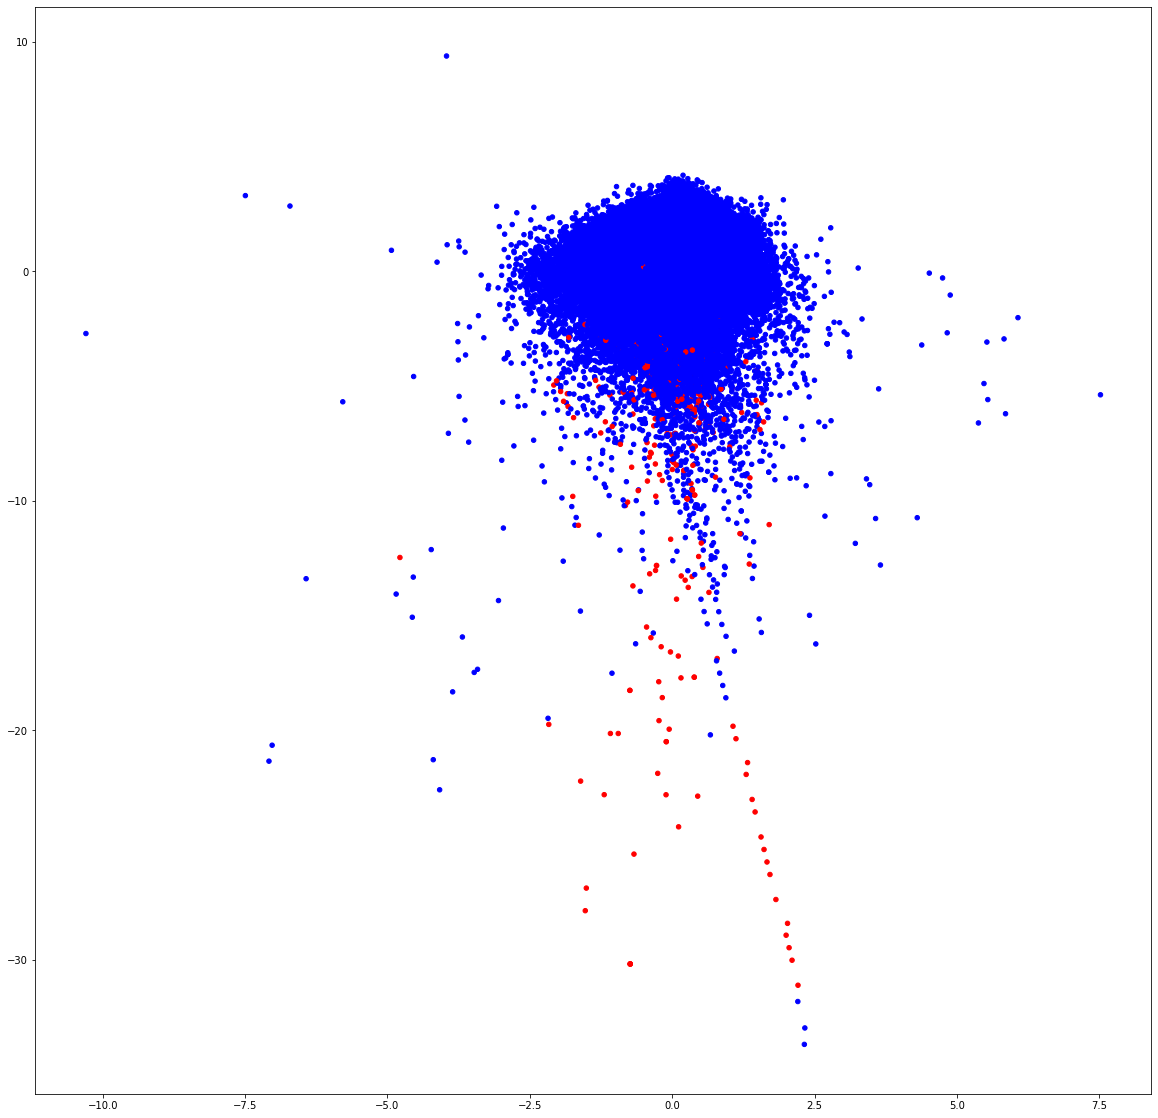

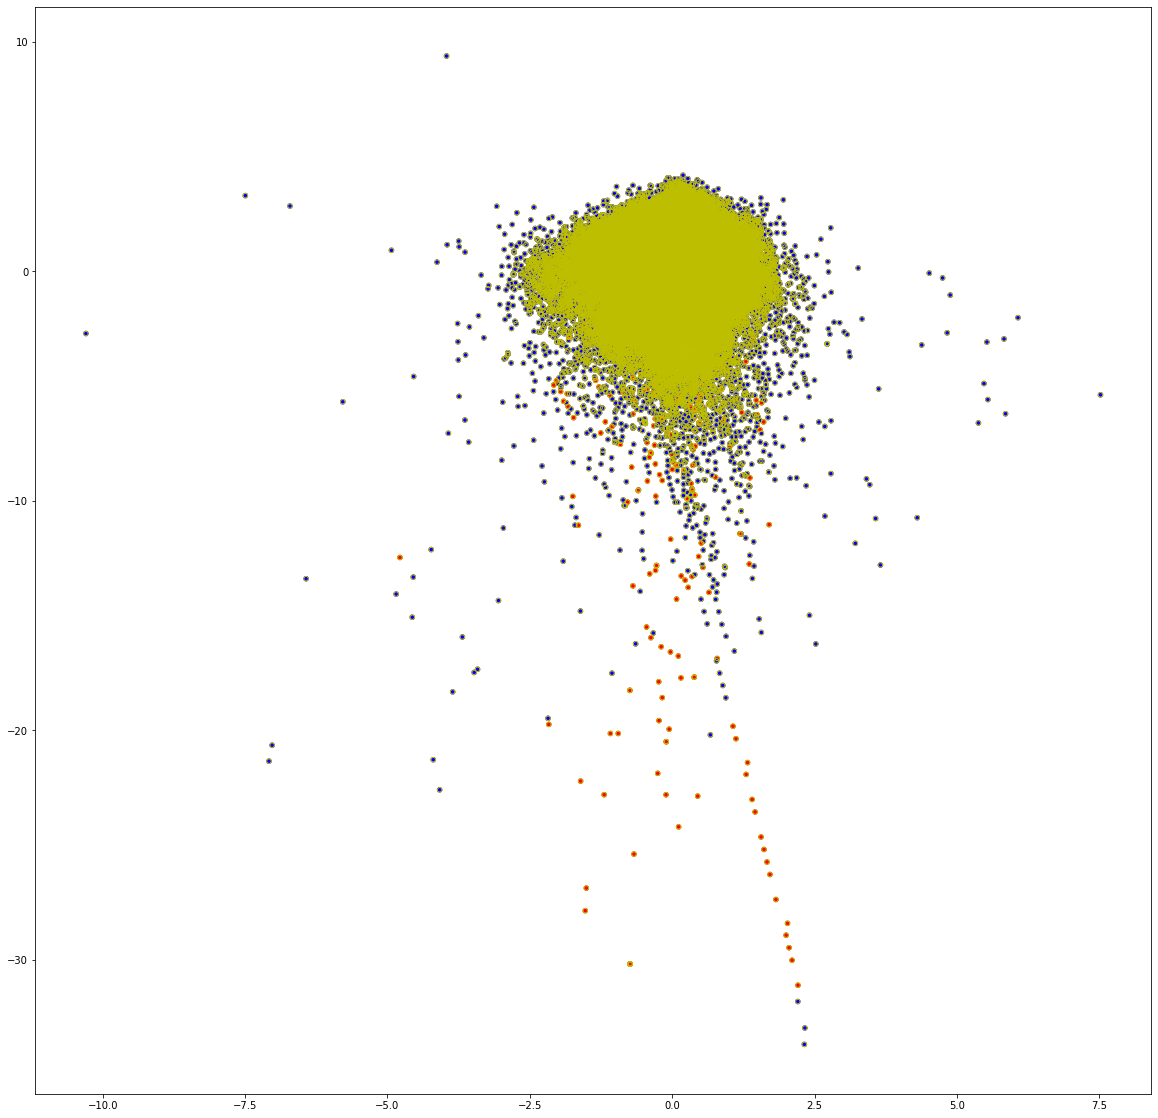

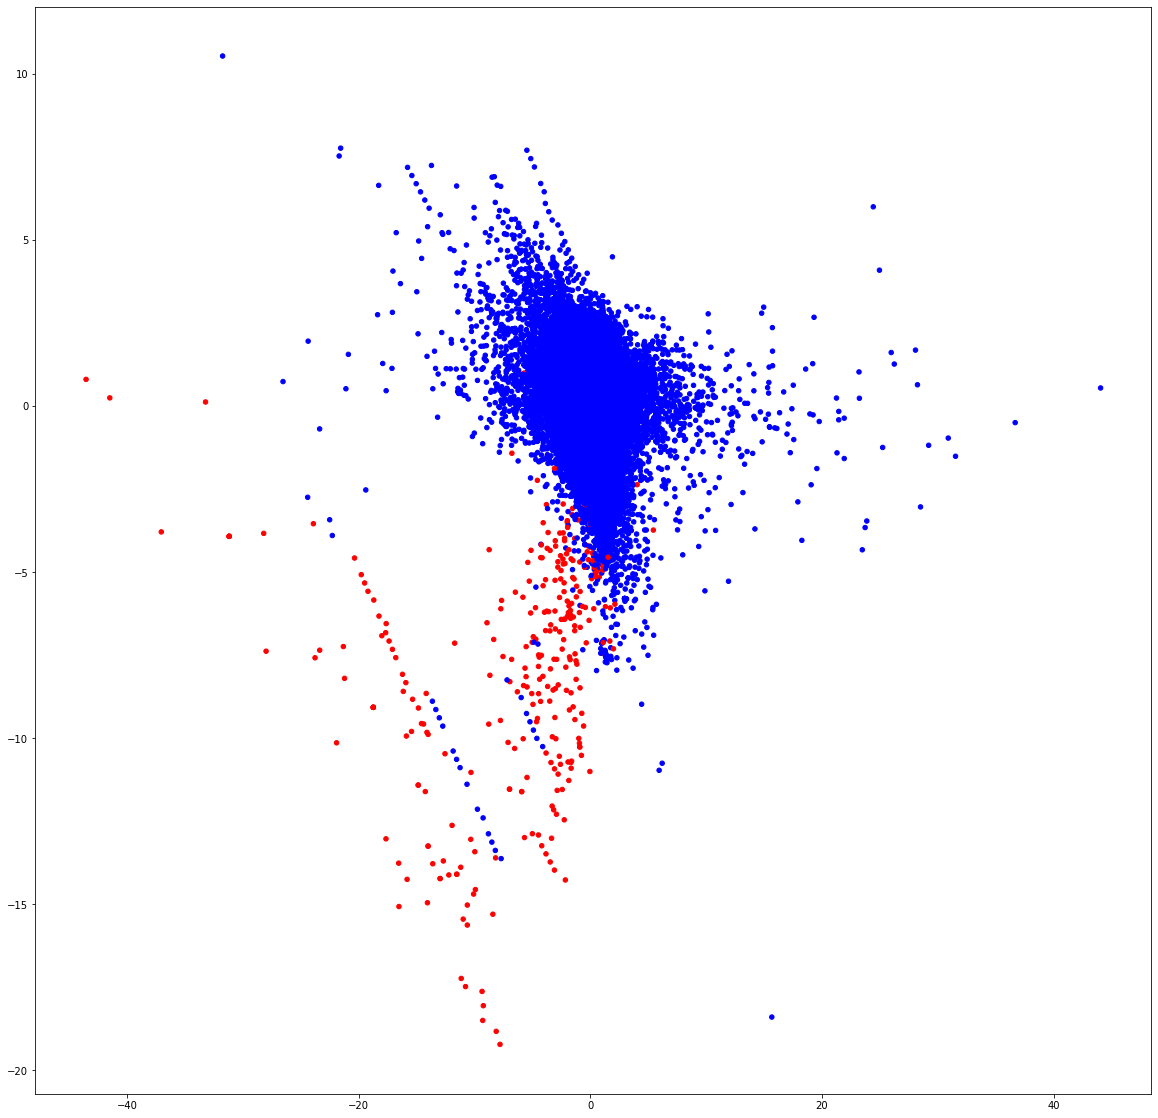

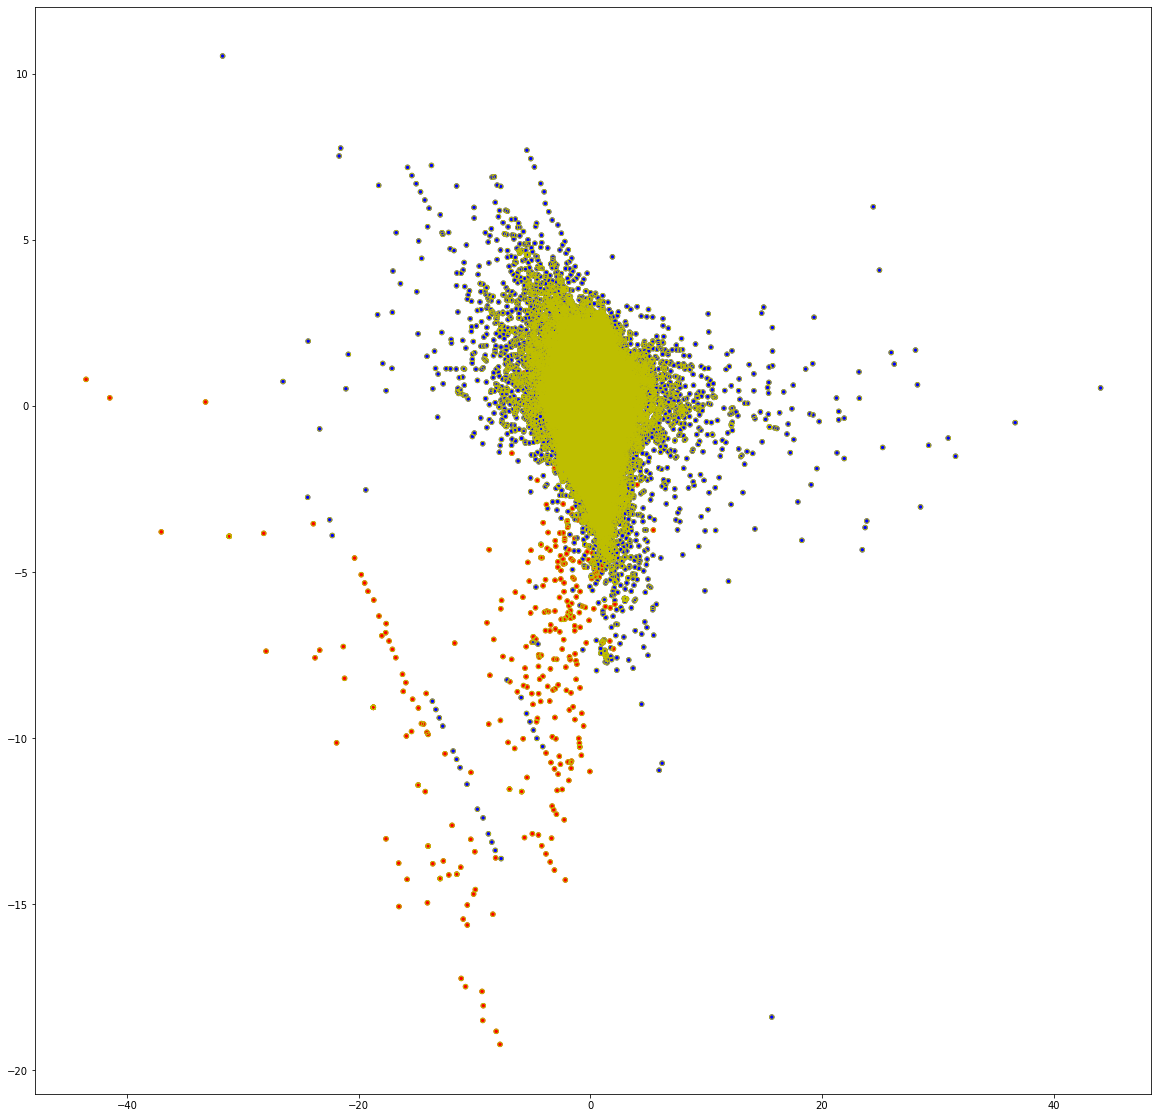

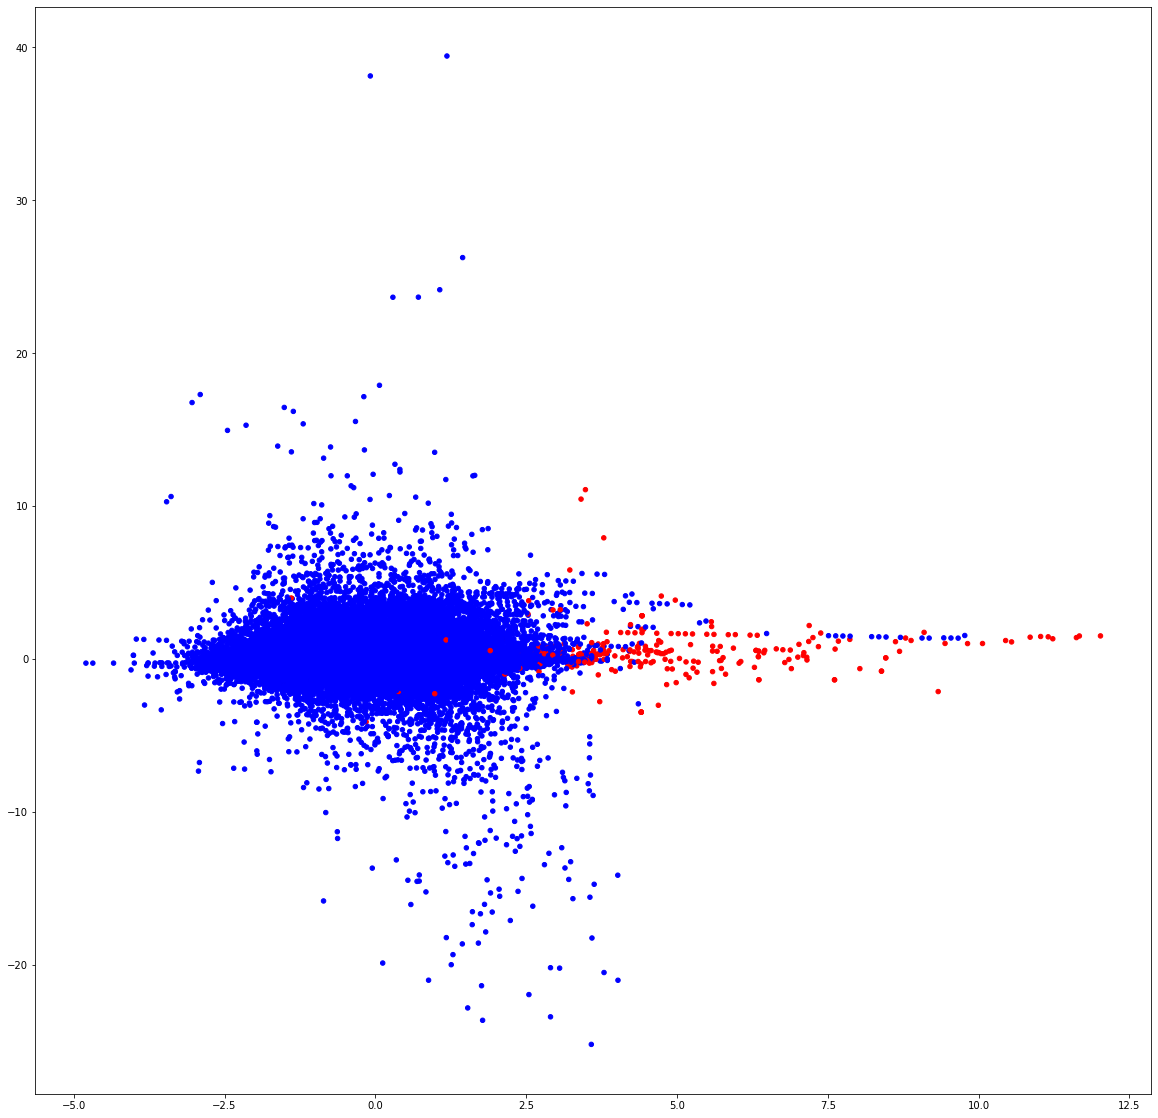

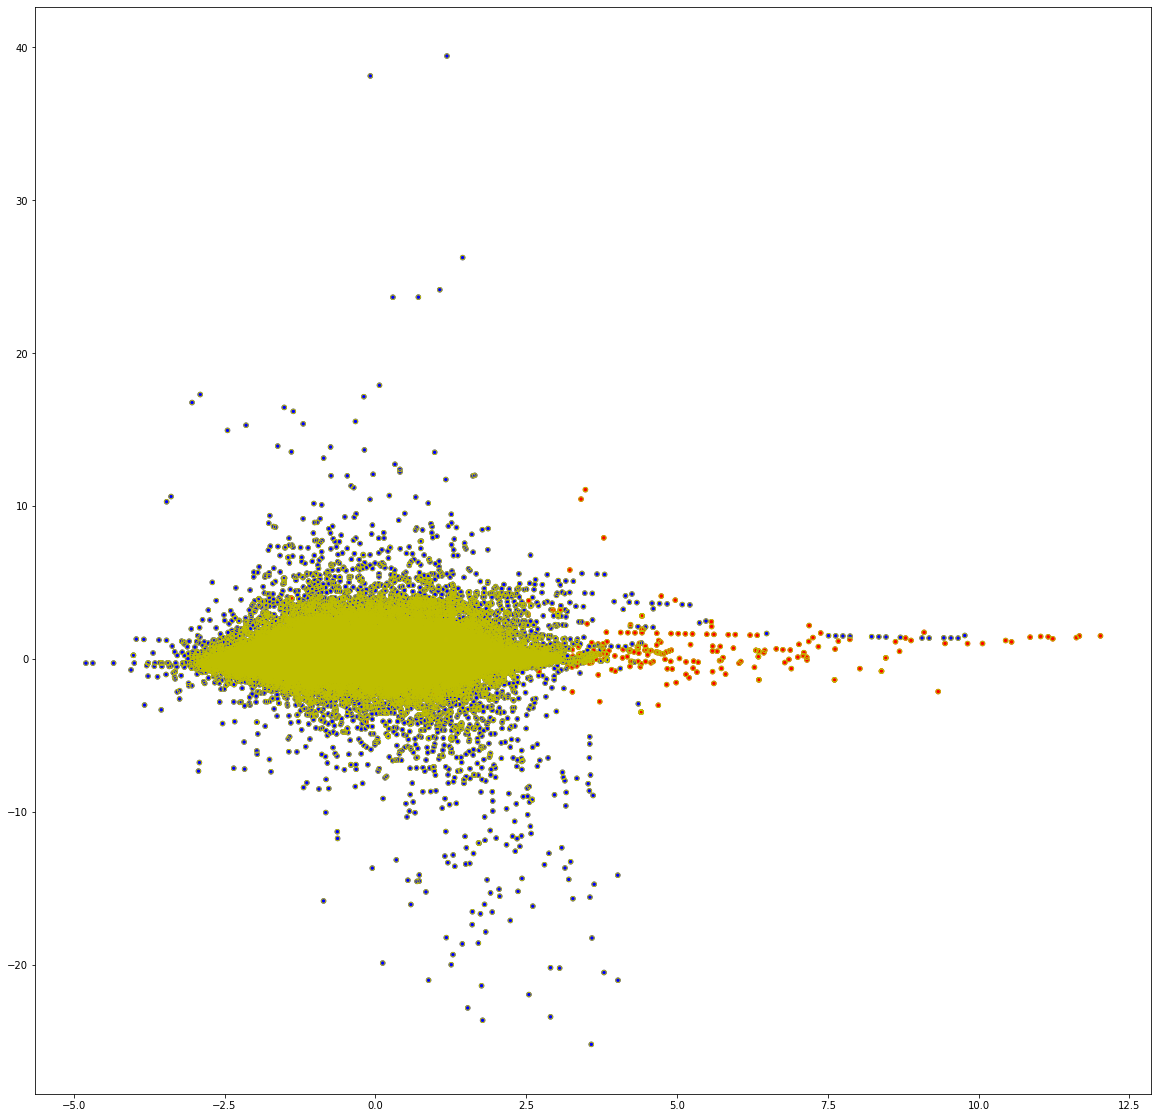

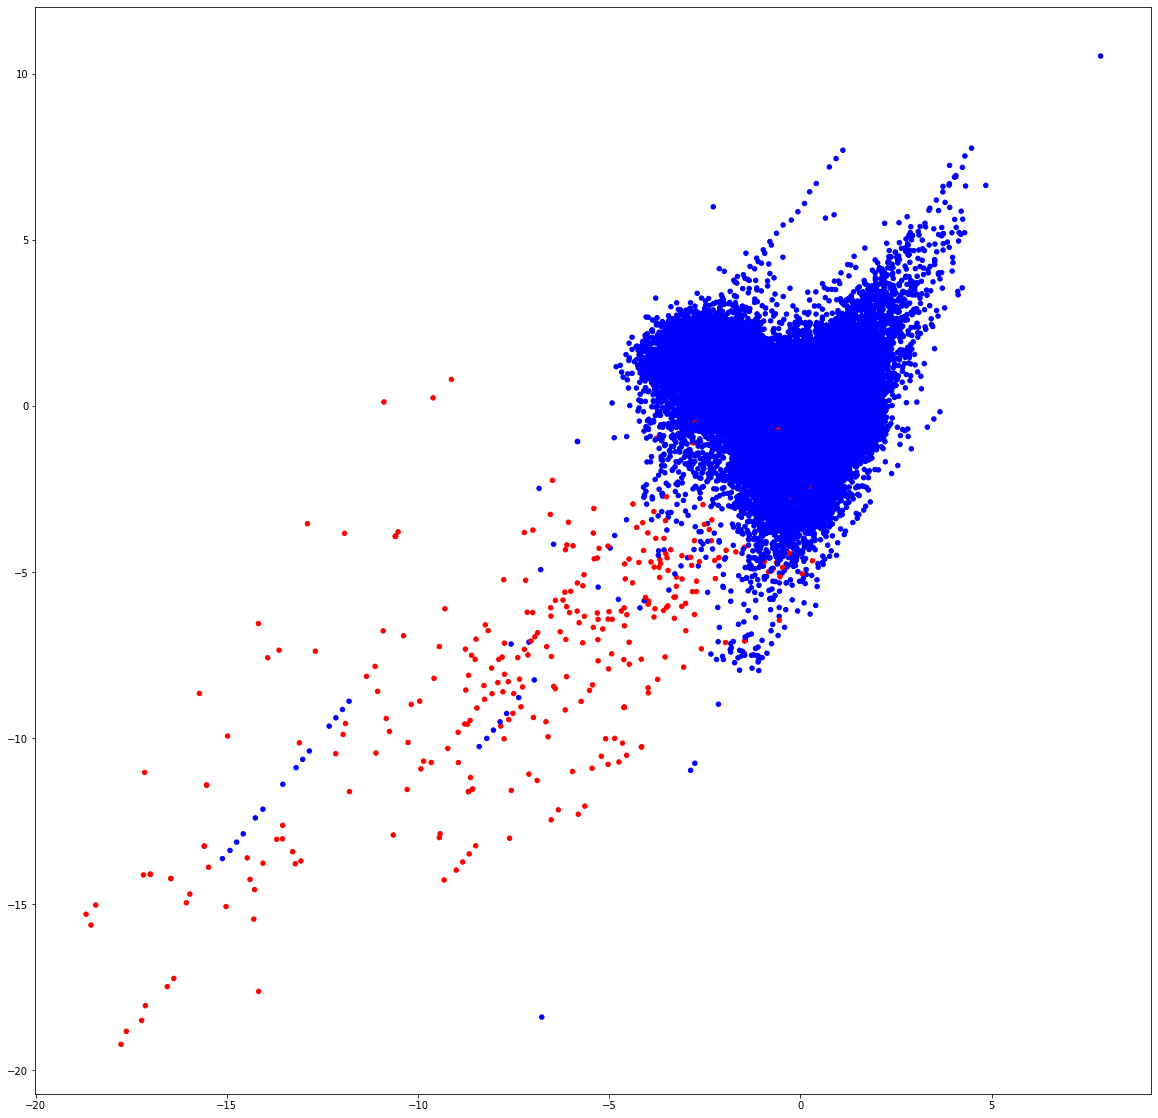

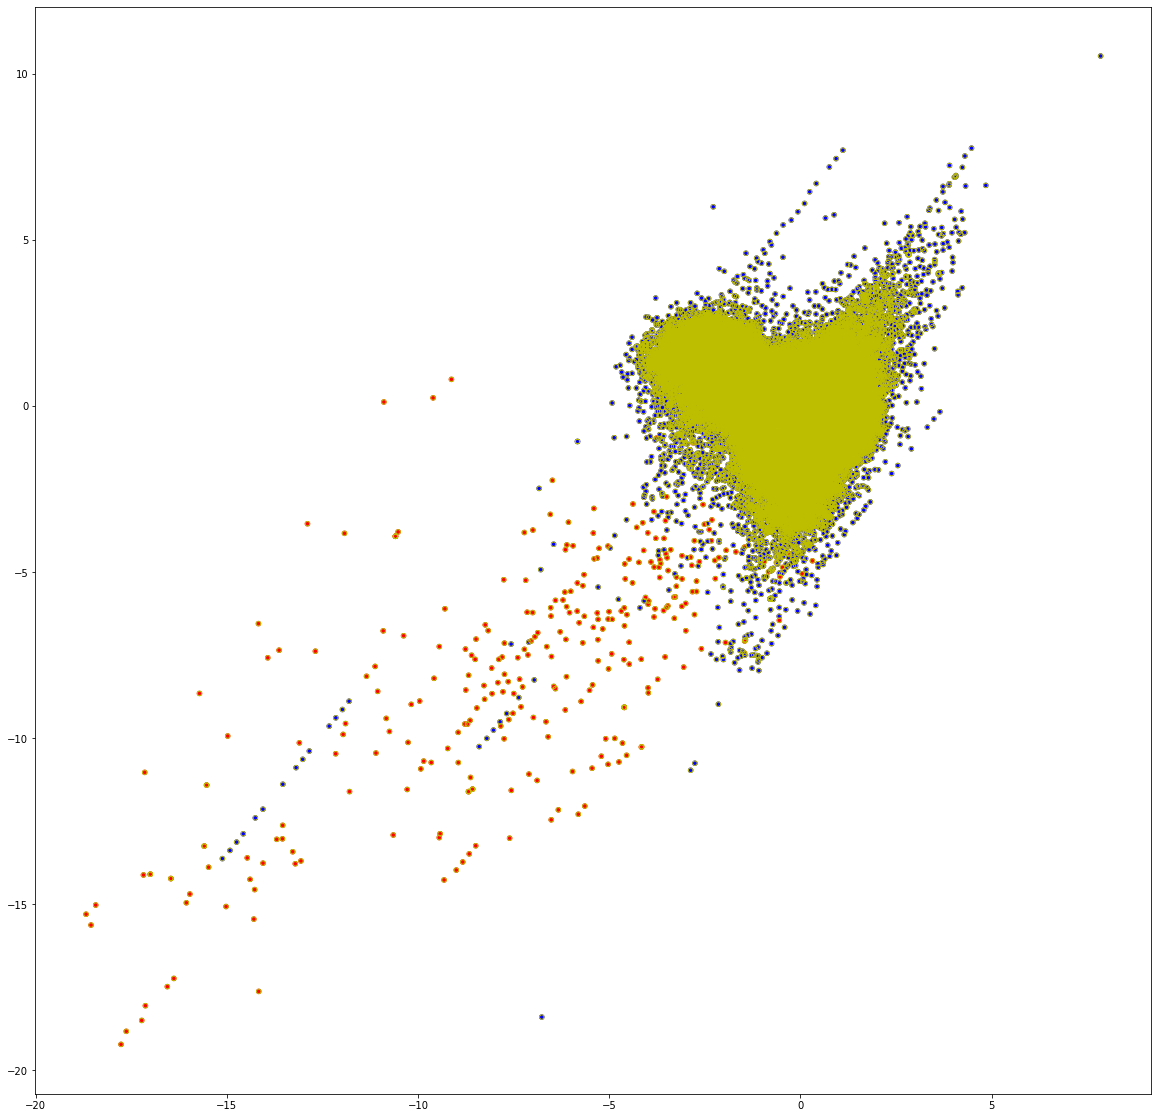

In [12]:
#Pair 1
F1_list1 = []
plot = plt.figure(figsize=(20, 20))
plt.scatter(X_train['V25'], X_train['V3'], c = y_train.map({1: 'red', 0: 'blue'}), s = 20)
#From the figure we could observe that the valid transaction features have about 1 cluster.

gm = GaussianMixture(n_components = 1, covariance_type = 'full', random_state=0)
gm.fit(X_train)
p_gm = gm.score_samples(X_train)
p_gm_val = gm.score_samples(X_val)

fpr_gm, tpr_gm, _ = roc_curve(y_train, 1-p_gm)
fpr_gm_val, tpr_gm_val, _ = roc_curve(y_val, 1-p_gm_val)
area_train = auc(fpr_gm, tpr_gm)
area_val = auc(fpr_gm_val, tpr_gm_val)

print('Pair 1 train and val auc:', area_train,',' ,area_val)

for i in range(1, 1000):
    threshold = sorted(p_gm_val)[i]
    F1 = f1_score(y_val, p_gm_val < threshold)
    F1_list1.append(F1)
print("Pair 1 Highest F1 is:", max(F1_list1))
print("Pair 1 threshold is:", p_gm_val[np.array(F1_list1).argmax()])

plot = plt.figure(figsize=(20, 20))
outliers = np.nonzero(p_gm < p_gm_val[np.array(F1_list1).argmax()])[0]
plt.scatter(X_train['V25'], X_train['V3'], c = y_train.map({1: 'red', 0: 'blue'}), s = 20)
plt.scatter(np.array(X_train['V25'])[outliers],np.array(X_train['V3'])[outliers],marker="o",facecolor= "none",edgecolor="y",s=20)

#Pair 2
F1_list2 = []

plot = plt.figure(figsize=(20, 20))
plt.scatter(X_train['V7'], X_train['V14'], c = y_train.map({1: 'red', 0: 'blue'}), s = 20)
#From the figure we could observe that the valid transaction features have about 2 clusters.

gm = GaussianMixture(n_components = 2, covariance_type = 'full', random_state=0)
gm.fit(X_train)
p_gm = gm.score_samples(X_train)
p_gm_val = gm.score_samples(X_val)
fpr_gm, tpr_gm, _ = roc_curve(y_train, 1-p_gm)
fpr_gm_val, tpr_gm_val, _ = roc_curve(y_val, 1-p_gm_val)
area_train = auc(fpr_gm, tpr_gm)
area_val = auc(fpr_gm_val, tpr_gm_val)
print('Pair 2 train and val auc:', area_train,',' ,area_val)
for i in range(1, 1000):
    threshold = sorted(p_gm_val)[i]
    F1 = f1_score(y_val, p_gm_val < threshold)
    F1_list2.append(F1)
print("Pair 2 Highest F1 is:", max(F1_list2))
print("Pair 2 threshold is:", p_gm_val[np.array(F1_list2).argmax()])

plot = plt.figure(figsize=(20, 20))
outliers = np.nonzero(p_gm < p_gm_val[np.array(F1_list1).argmax()])[0]
plt.scatter(X_train['V7'], X_train['V14'], c = y_train.map({1: 'red', 0: 'blue'}), s = 20)
plt.scatter(np.array(X_train['V7'])[outliers],np.array(X_train['V14'])[outliers],marker="o",facecolor= "none",edgecolor="y",s=20)

#Pair 3
F1_list3 = []
plot = plt.figure(figsize=(20, 20))
plt.scatter(X_train['V11'], X_train['V20'], c = y_train.map({1: 'red', 0: 'blue'}), s = 20)
#From the figure we could observe that the valid transaction features have about 2 clusters.

gm = GaussianMixture(n_components = 2, covariance_type = 'full', random_state=0)
gm.fit(X_train)
p_gm = gm.score_samples(X_train)
p_gm_val = gm.score_samples(X_val)
fpr_gm, tpr_gm, _ = roc_curve(y_train, 1-p_gm)
fpr_gm_val, tpr_gm_val, _ = roc_curve(y_val, 1-p_gm_val)
area_train = auc(fpr_gm, tpr_gm)
area_val = auc(fpr_gm_val, tpr_gm_val)
print('Pair 3 train and val auc:', area_train,',' ,area_val)
for i in range(1, 1000):
    threshold = sorted(p_gm_val)[i]
    F1 = f1_score(y_val, p_gm_val < threshold)
    F1_list3.append(F1)
print("Pair 3 Highest F1 is:", max(F1_list3))
print("Pair 3 threshold is:", p_gm_val[np.array(F1_list3).argmax()])
plot = plt.figure(figsize=(20, 20))
outliers = np.nonzero(p_gm < p_gm_val[np.array(F1_list1).argmax()])[0]
plt.scatter(X_train['V11'], X_train['V20'], c = y_train.map({1: 'red', 0: 'blue'}), s = 20)
plt.scatter(np.array(X_train['V11'])[outliers],np.array(X_train['V20'])[outliers],marker="o",facecolor= "none",edgecolor="y",s=20)

#Pair 4
F1_list4 = []

plot = plt.figure(figsize=(20, 20))
plt.scatter(X_train['V12'], X_train['V14'], c = y_train.map({1: 'red', 0: 'blue'}), s = 20)
#From the figure we could observe that the valid transaction features have about 3 clusters.

gm = GaussianMixture(n_components = 3, covariance_type = 'full', random_state=0)
gm.fit(X_train)
p_gm = gm.score_samples(X_train)
p_gm_val = gm.score_samples(X_val)
fpr_gm, tpr_gm, _ = roc_curve(y_train, 1-p_gm)
fpr_gm_val, tpr_gm_val, _ = roc_curve(y_val, 1-p_gm_val)
area_train = auc(fpr_gm, tpr_gm)
area_val = auc(fpr_gm_val, tpr_gm_val)
print('Pair 4 train and val auc:', area_train,',' ,area_val)
for i in range(1, 1000):
    threshold = sorted(p_gm_val)[i]
    F1 = f1_score(y_val, p_gm_val < threshold)
    F1_list4.append(F1)
print("Pair 4 Highest F1 is:", max(F1_list4))
print("Pair 4 threshold is:", p_gm_val[np.array(F1_list4).argmax()])
plot = plt.figure(figsize=(20, 20))
outliers = np.nonzero(p_gm < p_gm_val[np.array(F1_list1).argmax()])[0]
plt.scatter(X_train['V12'], X_train['V14'], c = y_train.map({1: 'red', 0: 'blue'}), s = 20)
plt.scatter(np.array(X_train['V12'])[outliers],np.array(X_train['V14'])[outliers],marker="o",facecolor= "none",edgecolor="y",s=20)


## **Part 4: Single feature model with two Gaussian distributions. [2 Marks]**
Now we will use two different distributions for fraudulent and non-fraudulent transactions.
  1.  Fit a Gaussian distribution ($G_1$) on a feature of **non-fraudulent transactions** using ``sklearn.mixture.GaussianMixture`` when ``n_components=1``. **[0.25]**
  2. Fit another Gaussian distribution ($G_2$) on the same feature but for **fraudulent transactions** using ``sklearn.mixture.GaussianMixture`` when ``n_components=1``. **[0.25]**
  3. Compute the score samples ($S$) for both $G_1$ and $G_2$ on the **validation set** to get $S_1$ and $S_2$, respectively. **[0.25]**
  4. Find an optimal $c$ (a real number) that maximizes validation set F1 Score for a model such that if $S_1 < c \times S_2$, the transaction is classified as a fraud. For example, if $c=1$ we could say that if $S_2$ is greater than $S_1$, ($S_1$<$S_2$) then the transaction is a fraud (the transaction belongs to the $G_2$ distribution which represents fraudulent transactions). For start consider $c$ in $[0,10]$ with steps of 0.1, you can change this window in your experiments if needed. **[0.25]**
  5. Repeat the steps above for all the features. What is the best F1 Score that you get for training and validation? Which feature and what c? **[1]**

In [13]:
X0 = df.drop(['Time','Amount'], axis=1)
X0 = X0[X0.iloc[:, -1] == 0]
y0 = df['Class'][df['Class'] == 0]

X1 = df.drop(['Time','Amount'], axis=1)
X1 = X1[X1.iloc[:, -1] == 1]
y1 = df['Class'][df['Class'] == 1]

X0_train, X0_test, y0_train, y0_test = train_test_split(X0, y0, test_size=0.15, random_state=0)
X0_train, X0_val, y0_train, y0_val = train_test_split(X0_train, y0_train, test_size= 15/(15+70), random_state=0)

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.15, random_state=0)
X1_train, X1_val, y1_train, y1_val = train_test_split(X1_train, y1_train, test_size= 15/(15+70), random_state=0)


In [201]:
F1_list = []

gm0 = GaussianMixture(n_components = 1, covariance_type = 'full', random_state=0)
gm0.fit(X0_train['V14'].values.reshape(-1,1))
p0_gm = gm0.score_samples(X_val['V14'].values.reshape(-1,1))

gm1 =  GaussianMixture(n_components = 1, covariance_type = 'full', random_state=0)
gm1.fit(X1_train['V14'].values.reshape(-1,1))
p1_gm = gm1.score_samples(X_val['V14'].values.reshape(-1,1))

for c in np.arange(0, 10, 0.1):
    F1 = f1_score(y_val, p0_gm < c*p1_gm)
    F1_list.append(F1)
print('V14 optimal c:', np.argmax(F1_list)*0.1, 'The highest F1', np.max(F1_list))

V14 optimal c: 5.6000000000000005 The highest F1 0.64


In [206]:
for i in range(28):
    gm0 = GaussianMixture(n_components = 1, covariance_type = 'full', random_state=0)
    gm0.fit(X0_train.iloc[:, i].values.reshape(-1,1))
    p0_gm = gm0.score_samples(X_val.iloc[:, i].values.reshape(-1,1))

    gm1 =  GaussianMixture(n_components = 1, covariance_type = 'full', random_state=0)
    gm1.fit(X1_train.iloc[:, i].values.reshape(-1,1))
    p1_gm = gm1.score_samples(X_val.iloc[:, i].values.reshape(-1,1))

    for c in np.arange(0, 10, 0.1):
        F1 = f1_score(y_val, p0_gm < c*p1_gm)
        F1_list.append(F1)
    print('V',i+1, 'optimal c:', np.argmax(F1_list)*0.1, 'The highest F1', np.max(F1_list))

V 1 optimal c: 5.6000000000000005 The highest F1 0.64
V 2 optimal c: 5.6000000000000005 The highest F1 0.64
V 3 optimal c: 5.6000000000000005 The highest F1 0.64
V 4 optimal c: 5.6000000000000005 The highest F1 0.64
V 5 optimal c: 5.6000000000000005 The highest F1 0.64
V 6 optimal c: 5.6000000000000005 The highest F1 0.64
V 7 optimal c: 5.6000000000000005 The highest F1 0.64
V 8 optimal c: 5.6000000000000005 The highest F1 0.64
V 9 optimal c: 5.6000000000000005 The highest F1 0.64
V 10 optimal c: 5.6000000000000005 The highest F1 0.64
V 11 optimal c: 5.6000000000000005 The highest F1 0.64
V 12 optimal c: 5.6000000000000005 The highest F1 0.64
V 13 optimal c: 5.6000000000000005 The highest F1 0.64
V 14 optimal c: 5.6000000000000005 The highest F1 0.64
V 15 optimal c: 5.6000000000000005 The highest F1 0.64
V 16 optimal c: 5.6000000000000005 The highest F1 0.64
V 17 optimal c: 5.6000000000000005 The highest F1 0.64
V 18 optimal c: 5.6000000000000005 The highest F1 0.64
V 19 optimal c: 5.6

## **Part 5: Multivariate and Mixture of Gaussians Distribution [4 Marks]**
We now want to build an outlier detection model that performs well in terms of F1 score. To design your model, you can benefit from:

*   No restrictions on the number of features - use as few or as many as you want! (multivariate). 
*   To fit your model, you can take advantage of the Gaussian mixture model, where you can set the number of components [help](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html).
*   You can choose to fit your Gaussians on non-fraudulent transactions or to both classes. 


It is up to you how to design your model. Try at least 10 different models and report the AUC for both training and validation sets (if applicable) and the best F1 score for both training and validation sets for each model. What kind of model works better? How many features are best (and which ones)? How many Gaussians? How many components? Summarize your findings with tables or plots. **[4]**


**HINT !**

You might want to try a two-gaussian model, multiple features, a single component for the valid transaction, and multiple components for fraudulent ones! Why does it make sense to have multiple components for fraudulent transactions?

**Answer**: Fraudulent transactions dustributions are much different from each other, not like the valid transcation distribution which are similar and have mean at 0.

In [8]:
X = df.drop(['Time','Amount','Class'], axis=1)
y = df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size= 15/(15+70), random_state=0)

**Use all features, n_component = 1,2,3**

In [48]:
#Model 1
F1_train1 = []
F1_val1 = []

gm1 = GaussianMixture(n_components = 1, covariance_type = 'full', random_state=0)
gm1.fit(X_train)
p_gm = gm1.score_samples(X_train)
p_gm_val = gm1.score_samples(X_val)
fpr_gm, tpr_gm, _ = roc_curve(y_train, 1-p_gm)
fpr_gm_val, tpr_gm_val, _ = roc_curve(y_val, 1-p_gm_val)
area_train = auc(fpr_gm, tpr_gm)
area_val = auc(fpr_gm_val, tpr_gm_val)
print('Model 1 train and val auc:', area_train,',' ,area_val)

for i in range(1000):
    threshold_train = sorted(p_gm)[i]
    threshold_val = sorted(p_gm_val)[i]
    F1_train = f1_score(y_train, p_gm < threshold_train)
    F1_val = f1_score(y_val, p_gm_val < threshold_val)
    F1_train1.append(F1_train)
    F1_val1.append(F1_val)
print("Model 1 Highest F1 for train and val are:", max(F1_train1),',', max(F1_val1))
print("Model 1 thresholds for train and val are:", p_gm[np.array(F1_train1).argmax()],',', p_gm_val[np.array(F1_val1).argmax()])

#Model 2
F1_train2 = []
F1_val2 = []

gm2 = GaussianMixture(n_components = 2, covariance_type = 'full', random_state=0)
gm2.fit(X_train)
p_gm = gm2.score_samples(X_train)
p_gm_val = gm2.score_samples(X_val)
fpr_gm, tpr_gm, _ = roc_curve(y_train, 1-p_gm)
fpr_gm_val, tpr_gm_val, _ = roc_curve(y_val, 1-p_gm_val)
area_train = auc(fpr_gm, tpr_gm)
area_val = auc(fpr_gm_val, tpr_gm_val)
print('Model 2 train and val auc:', area_train,',' ,area_val)

for i in range(1000):
    threshold_train = sorted(p_gm)[i]
    threshold_val = sorted(p_gm_val)[i]
    F1_train = f1_score(y_train, p_gm < threshold_train)
    F1_val = f1_score(y_val, p_gm_val < threshold_val)
    F1_train2.append(F1_train)
    F1_val2.append(F1_val)

print("Model 2 Highest F1 for train and val are:", max(F1_train2),',', max(F1_val2))
print("Model 2 thresholds for train and val are:", p_gm[np.array(F1_train2).argmax()],',', p_gm_val[np.array(F1_val2).argmax()])

#Model 3
F1_train3 = []
F1_val3 = []

gm3 = GaussianMixture(n_components = 3, covariance_type = 'full', random_state=0)
gm3.fit(X_train)
p_gm = gm3.score_samples(X_train)
p_gm_val = gm3.score_samples(X_val)
fpr_gm, tpr_gm, _ = roc_curve(y_train, 1-p_gm)
fpr_gm_val, tpr_gm_val, _ = roc_curve(y_val, 1-p_gm_val)
area_train = auc(fpr_gm, tpr_gm)
area_val = auc(fpr_gm_val, tpr_gm_val)
print('Model 3 train and val auc:', area_train,',' ,area_val)

for i in range(1000):
    threshold_train = sorted(p_gm)[i]
    threshold_val = sorted(p_gm_val)[i]
    F1_train = f1_score(y_train, p_gm < threshold_train)
    F1_val = f1_score(y_val, p_gm_val < threshold_val)
    F1_train3.append(F1_train)
    F1_val3.append(F1_val)

print("Model 3 Highest F1 for train and val are:", max(F1_train3),',', max(F1_val3))
print("Model 3 thresholds for train and val are:", p_gm[np.array(F1_train3).argmax()],',', p_gm_val[np.array(F1_val3).argmax()])

Model 1 train and val auc: 0.9534850819614004 , 0.9434617299496103
Model 1 Highest F1 for train and val are: 0.2949640287769784 , 0.32323232323232326
Model 1 thresholds for train and val are: -45.034097910083794 , -35.7115219753566
Model 2 train and val auc: 0.936089393366667 , 0.93226265454218
Model 2 Highest F1 for train and val are: 0.28975265017667845 , 0.3076923076923077
Model 2 thresholds for train and val are: 15.596065658724143 , -32.511046987296574
Model 3 train and val auc: 0.9273885907488507 , 0.9320438600995589
Model 3 Highest F1 for train and val are: 0.2887249736564805 , 0.297029702970297
Model 3 thresholds for train and val are: -46.30541048649315 , -56.139038014022546


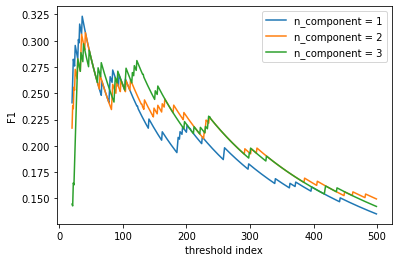

In [51]:
plt.plot(range(20,500),F1_val1[20:500],label='n_component = 1')
plt.plot(range(20,500),F1_val2[20:500], label='n_component = 2')
plt.plot(range(20,500),F1_val3[20:500], label='n_component = 3')
plt.xlabel('threshold index')
plt.ylabel('F1')
plt.legend()
plt.show()


F1 does not performe well, all below 0.325. At each curves' peak point, the larger the n, the smaller the max F1. n increase, the model gets more complicated, try to learn all the distributions,including both good one and bad one, by itself without learning from the class label. The accuracy will be low.

**Fit non-fradulent only**

In [31]:
X = df.drop(['Time','Amount','Class'], axis=1)
y = df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size= 15/(15+70), random_state=0)

In [32]:
X_trainj = X_train.join(y_train)
X_valj = X_val.join(y_val)

y0_train = y_train[y_train == 0]
y0_val = y_val[y_val == 0]
X0_train = X_trainj[X_trainj.iloc[:, -1] == 0].drop('Class', axis = 1)
X0_val = X_valj[X_valj.iloc[:, -1] == 0].drop('Class', axis = 1)


In [33]:
#Model 4
F1_train4 = []
F1_val4 = []

gm4 = GaussianMixture(n_components = 1, covariance_type = 'full', random_state=0)
gm4.fit(X0_train)
p_gm = gm4.score_samples(X_train)
p_gm_val = gm4.score_samples(X_val)
fpr_gm, tpr_gm, _ = roc_curve(y_train, 1-p_gm)
fpr_gm_val, tpr_gm_val, _ = roc_curve(y_val, 1-p_gm_val)
area_train = auc(fpr_gm, tpr_gm)
area_val = auc(fpr_gm_val, tpr_gm_val)
print('Model 4 train and val auc:', area_train,',' ,area_val)

for i in range(1000):
    threshold_train = sorted(p_gm)[i]
    threshold_val = sorted(p_gm_val)[i]
    F1_train = f1_score(y_train, p_gm < threshold_train)
    F1_val = f1_score(y_val, p_gm_val < threshold_val)
    F1_train4.append(F1_train)
    F1_val4.append(F1_val)
print("Model 4 Highest F1 for train and val are:", max(F1_train4),',', max(F1_val4))
print("Model 4 thresholds for train and val are:", p_gm[np.array(F1_train4).argmax()],',', p_gm_val[np.array(F1_val4).argmax()])

#Model 5
F1_train5 = []
F1_val5 = []

gm5 = GaussianMixture(n_components = 2, covariance_type = 'full', random_state=0)
gm5.fit(X0_train)
p_gm = gm5.score_samples(X_train)
p_gm_val = gm5.score_samples(X_val)
fpr_gm, tpr_gm, _ = roc_curve(y_train, 1-p_gm)
fpr_gm_val, tpr_gm_val, _ = roc_curve(y_val, 1-p_gm_val)
area_train = auc(fpr_gm, tpr_gm)
area_val = auc(fpr_gm_val, tpr_gm_val)
print('Model 5 train and val auc:', area_train,',' ,area_val)

for i in range(1000):
    threshold_train = sorted(p_gm)[i]
    threshold_val = sorted(p_gm_val)[i]
    F1_train = f1_score(y_train, p_gm < threshold_train)
    F1_val = f1_score(y_val, p_gm_val < threshold_val)
    F1_train5.append(F1_train)
    F1_val5.append(F1_val)

print("Model 5 Highest F1 for train and val are:", max(F1_train5),',', max(F1_val5))
print("Model 5 thresholds for train and val are:", p_gm[np.array(F1_train5).argmax()],',', p_gm_val[np.array(F1_val5).argmax()])

#Model 6
F1_train6 = []
F1_val6 = []

gm6 = GaussianMixture(n_components = 3, covariance_type = 'full', random_state=0)
gm6.fit(X0_train)
p_gm = gm6.score_samples(X_train)
p_gm_val = gm6.score_samples(X_val)
fpr_gm, tpr_gm, _ = roc_curve(y_train, 1-p_gm)
fpr_gm_val, tpr_gm_val, _ = roc_curve(y_val, 1-p_gm_val)
area_train = auc(fpr_gm, tpr_gm)
area_val = auc(fpr_gm_val, tpr_gm_val)
print('Model 6 train and val auc:', area_train,',' ,area_val)

for i in range(1000):
    threshold_train = sorted(p_gm)[i]
    threshold_val = sorted(p_gm_val)[i]
    F1_train = f1_score(y_train, p_gm < threshold_train)
    F1_val = f1_score(y_val, p_gm_val < threshold_val)
    F1_train6.append(F1_train)
    F1_val6.append(F1_val)

print("Model 6 Highest F1 for train and val are:", max(F1_train6),',', max(F1_val6))
print("Model 6 thresholds for train and val are:", p_gm[np.array(F1_train6).argmax()],',', p_gm_val[np.array(F1_val6).argmax()])

Model 4 train and val auc: 0.9584089444889569 , 0.9487295410451677
Model 4 Highest F1 for train and val are: 0.5557206537890045 , 0.5384615384615384
Model 4 thresholds for train and val are: -26.87637911635833 , -30.06895799439708
Model 5 train and val auc: 0.9336634290515136 , 0.9353998245179266
Model 5 Highest F1 for train and val are: 0.5404624277456647 , 0.5212765957446809
Model 5 thresholds for train and val are: -30.041795965940665 , -37.059567438909276
Model 6 train and val auc: 0.9334893977121426 , 0.9402196279452597
Model 6 Highest F1 for train and val are: 0.5649717514124294 , 0.5396825396825397
Model 6 thresholds for train and val are: -8.59536669398706 , 45.62174774987883


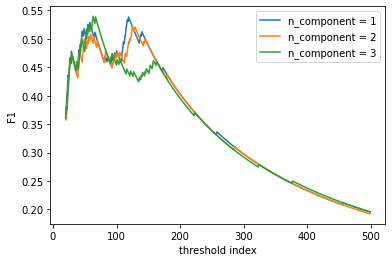

In [34]:
plt.plot(range(20,500),F1_val4[20:500],label='n_component = 1')
plt.plot(range(20,500),F1_val5[20:500], label='n_component = 2')
plt.plot(range(20,500),F1_val6[20:500], label='n_component = 3')
plt.xlabel('threshold index')
plt.ylabel('F1')
plt.legend()
plt.show()

Fit all features with different n 1, 2, 3. Overall f1 score is generally increasing as n increase. In these three model, the models know that all the datas are from non-fradulent with class = 0. The model will only fit the non-fradulent more accuratly to their different distributions with larger  (more types of distributions could be modeled).

**Two Gaussian**

In [56]:
#Model 7 - all features, n = 1 & 
F1_train7 = []
F1_val7 = []

gm0 = GaussianMixture(n_components = 1, covariance_type = 'full', random_state=0)
gm0.fit(X0_train)
p0_gm = gm0.score_samples(X_train)
p0_gm_val = gm0.score_samples(X_val)


gm1 =  GaussianMixture(n_components = 1, covariance_type = 'full', random_state=0)
gm1.fit(X1_train)
p1_gm = gm1.score_samples(X_train)
p1_gm_val = gm1.score_samples(X_val)

for c in np.arange(0, 10, 0.1):
    F1_train = f1_score(y_train, p0_gm < c*p1_gm)
    F1_train7.append(F1_train)

    F1_val = f1_score(y_val, p0_gm_val < c*p1_gm_val)
    F1_val7.append(F1_val)
print('Model 7, Optimal c for train and val:', np.argmax(F1_train7)*0.1,',', np.argmax(F1_val7)*0.1)
print('Model 7, The highest F1 for train and val', np.max(F1_train7),',', np.max(F1_val7))



#Model 8 - all features
F1_train8 = []
F1_val8 = []

gm0 = GaussianMixture(n_components = 3, covariance_type = 'full', random_state=0)
gm0.fit(X0_train)
p0_gm = gm0.score_samples(X_train)
p0_gm_val = gm0.score_samples(X_val)


gm1 =  GaussianMixture(n_components = 3, covariance_type = 'full', random_state=0)
gm1.fit(X1_train)
p1_gm = gm1.score_samples(X_train)
p1_gm_val = gm1.score_samples(X_val)

for c in np.arange(0, 10, 0.1):
    F1_train = f1_score(y_train, p0_gm < c*p1_gm)
    F1_train8.append(F1_train)

    F1_val = f1_score(y_val, p0_gm_val < c*p1_gm_val)
    F1_val8.append(F1_val)
print('Model 8, Optimal c for train and val:', np.argmax(F1_train8)*0.1,',', np.argmax(F1_val8)*0.1)
print('Model 8, The highest F1 for train and val', np.max(F1_train8),',', np.max(F1_val8))

#Model 8_2 - all features
F1_train8_2 = []
F1_val8_2 = []

gm0 = GaussianMixture(n_components = 1, covariance_type = 'full', random_state=0)
gm0.fit(X0_train)
p0_gm = gm0.score_samples(X_train)
p0_gm_val = gm0.score_samples(X_val)


gm1 =  GaussianMixture(n_components = 3, covariance_type = 'full', random_state=0)
gm1.fit(X1_train)
p1_gm = gm1.score_samples(X_train)
p1_gm_val = gm1.score_samples(X_val)

for c in np.arange(0, 10, 0.1):
    F1_train = f1_score(y_train, p0_gm < c*p1_gm)
    F1_train8_2.append(F1_train)

    F1_val = f1_score(y_val, p0_gm_val < c*p1_gm_val)
    F1_val8_2.append(F1_val)
print('Model 8_2, Optimal c for train and val:', np.argmax(F1_train8_2)*0.1,',', np.argmax(F1_val8_2)*0.1)
print('Model 8_2, The highest F1 for train and val', np.max(F1_train8_2),',', np.max(F1_val8_2))

#Model 9 - V14, V12, V17, V10 four high F1 score features
F1_train9 = []
F1_val9 = []

gm0 = GaussianMixture(n_components = 1, covariance_type = 'full', random_state=0)
gm0.fit(X0_train[['V14', 'V12', 'V17', 'V10']])
p0_gm = gm0.score_samples(X_train[['V14', 'V12', 'V17', 'V10']])
p0_gm_val = gm0.score_samples(X_val[['V14', 'V12', 'V17', 'V10']])


gm1 =  GaussianMixture(n_components = 1, covariance_type = 'full', random_state=0)
gm1.fit(X1_train[['V14', 'V12', 'V17', 'V10']])
p1_gm = gm1.score_samples(X_train[['V14', 'V12', 'V17', 'V10']])
p1_gm_val = gm1.score_samples(X_val[['V14', 'V12', 'V17', 'V10']])

for c in np.arange(0, 10, 0.1):
    F1_train = f1_score(y_train, p0_gm < c*p1_gm)
    F1_train9.append(F1_train)

    F1_val = f1_score(y_val, p0_gm_val < c*p1_gm_val)
    F1_val9.append(F1_val)
print('Model 9, Optimal c for train and val:', np.argmax(F1_train9)*0.1,',', np.argmax(F1_val9)*0.1)
print('Model 9, The highest F1 for train and val', np.max(F1_train9),',', np.max(F1_val9))

#Model 10 - V14, V12, V17, V10 four high F1 score features
F1_train10 = []
F1_val10 = []

gm0 = GaussianMixture(n_components = 3, covariance_type = 'full', random_state=0)
gm0.fit(X0_train[['V14', 'V12', 'V17', 'V10']])
p0_gm = gm0.score_samples(X_train[['V14', 'V12', 'V17', 'V10']])
p0_gm_val = gm0.score_samples(X_val[['V14', 'V12', 'V17', 'V10']])


gm1 =  GaussianMixture(n_components = 3, covariance_type = 'full', random_state=0)
gm1.fit(X1_train[['V14', 'V12', 'V17', 'V10']])
p1_gm = gm1.score_samples(X_train[['V14', 'V12', 'V17', 'V10']])
p1_gm_val = gm1.score_samples(X_val[['V14', 'V12', 'V17', 'V10']])

for c in np.arange(0, 10, 0.1):
    F1_train = f1_score(y_train, p0_gm < c*p1_gm)
    F1_train10.append(F1_train)

    F1_val = f1_score(y_val, p0_gm_val < c*p1_gm_val)
    F1_val10.append(F1_val)
print('Model 10,Optimal c for train and val:', np.argmax(F1_train10)*0.1,',', np.argmax(F1_val10)*0.1)
print('Model 10,The highest F1 for train and val', np.max(F1_train10),',', np.max(F1_val10))

#Model 10_2 - V14, V12, V17, V10 four high F1 score features
F1_train10_2 = []
F1_val10_2 = []

gm0 = GaussianMixture(n_components = 1, covariance_type = 'full', random_state=0)
gm0.fit(X0_train[['V14', 'V12', 'V17', 'V10']])
p0_gm = gm0.score_samples(X_train[['V14', 'V12', 'V17', 'V10']])
p0_gm_val = gm0.score_samples(X_val[['V14', 'V12', 'V17', 'V10']])


gm1 =  GaussianMixture(n_components = 3, covariance_type = 'full', random_state=0)
gm1.fit(X1_train[['V14', 'V12', 'V17', 'V10']])
p1_gm = gm1.score_samples(X_train[['V14', 'V12', 'V17', 'V10']])
p1_gm_val = gm1.score_samples(X_val[['V14', 'V12', 'V17', 'V10']])

for c in np.arange(0, 10, 0.1):
    F1_train = f1_score(y_train, p0_gm < c*p1_gm)
    F1_train10_2.append(F1_train)

    F1_val = f1_score(y_val, p0_gm_val < c*p1_gm_val)
    F1_val10_2.append(F1_val)
print('Model 10_2, Optimal c for train and val:', np.argmax(F1_train10_2)*0.1,',', np.argmax(F1_val10_2)*0.1)
print('Model 10_2, The highest F1 for train and val', np.max(F1_train10_2),',', np.max(F1_val10_2))

Model 7, Optimal c for train and val: 7.9 , 6.2
Model 7, The highest F1 for train and val 0.7471264367816092 , 0.732394366197183
Model 8, Optimal c for train and val: 1.8 , 1.9000000000000001
Model 8, The highest F1 for train and val 0.7970588235294117 , 0.7596899224806201
Model 8_2, Optimal c for train and val: 6.9 , 4.9
Model 8_2, The highest F1 for train and val 0.8161434977578476 , 0.8346456692913385
Model 9, Optimal c for train and val: 6.1000000000000005 , 6.300000000000001
Model 9, The highest F1 for train and val 0.8059259259259259 , 0.819672131147541
Model 10,Optimal c for train and val: 2.0 , 2.4000000000000004
Model 10,The highest F1 for train and val 0.8115942028985507 , 0.7936507936507936
Model 10_2, Optimal c for train and val: 6.800000000000001 , 6.2
Model 10_2, The highest F1 for train and val 0.8174962292609351 , 0.8225806451612904


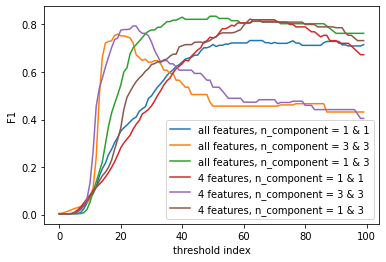

In [57]:
plt.plot(F1_val7,label='all features, n_component = 1 & 1')
plt.plot(F1_val8, label='all features, n_component = 3 & 3')
plt.plot(F1_val8_2, label='all features, n_component = 1 & 3')

plt.plot(F1_val9, label='4 features, n_component = 1 & 1')
plt.plot(F1_val10, label='4 features, n_component = 3 & 3')
plt.plot(F1_val10_2, label='4 features, n_component = 1 & 3')

plt.xlabel('threshold index')
plt.ylabel('F1')
plt.legend()
plt.show()

Use 2 Gaussians, with different n and training features. Model 8_2 has the highest val F1 0.835. Generally speaking, the model use 4 features to train will be higher than all features(including some hard distinguished data V13, V15, V22, V25), it shows some features are useless and some feature is significant to help the model make classification - the class depends much on those features.

Besides, the n = 1 & 3 has the relative better performance than 1 & 1 and 3 & 3, since non-fraud distribution are similar and fraud distribution are quite different from each other. Making fraud Gaussians n to be 3 is easy for model to classify fraud data.

## **Part 6: Evaluating performance on test set: [1 Mark]**
**Which model worked better?** Pick your best model among all models and apply it to your test set. Report the F1 Score, precision and recall on the test set. **[1]**


In [64]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
gm0 = GaussianMixture(n_components = 1, covariance_type = 'full', random_state=0)
gm0.fit(X0_train)
p0_gm = gm0.score_samples(X_test)

gm1 =  GaussianMixture(n_components = 3, covariance_type = 'full', random_state=0)
gm1.fit(X1_train)
p1_gm = gm1.score_samples(X_test)

F1_test = []
precisions_list = []
recalls_list = []
for c in np.arange(0, 10, 0.1):
    precision = precision_score(y_test, p0_gm < c*p1_gm)
    recall = recall_score(y_test, p0_gm < c*p1_gm)
    F1 = f1_score(y_test, p0_gm < c*p1_gm)
    F1_test.append(F1)
    precisions_list.append(precision)
    recalls_list.append(recall)
print('Optimal c is', np.argmax(F1_test)*0.1, 'Highest F1 score:', np.max(F1_test), 
      'Precision:', precisions_list[np.argmax(F1_test)], 'Recall:', recalls_list[np.argmax(F1_test)])

Optimal c is 7.2 Highest F1 score: 0.8085106382978724 Precision: 0.8507462686567164 Recall: 0.7702702702702703


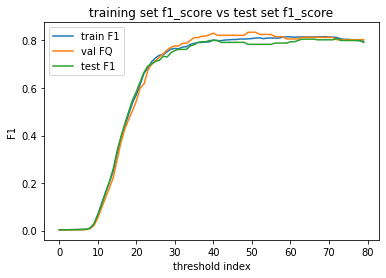

In [70]:
plt.plot(F1_train8_2[:80], label='train F1')
plt.plot(F1_val8_2[:80], label='val F1')
plt.plot(F1_test[:80], label='test F1')
plt.xlabel('threshold index')
plt.ylabel('F1')
plt.title('training set f1_score vs test set f1_score')
plt.legend()
plt.show()

Comment: **F1 for three dataset are similar, therefore there are no overfitting or underfitting problems.**

## **Part 7: Is Gaussian the only useful distribution? [1 Mark]**

Search for other distributions that could be used to model the data. How popular are they? Is there a specific situation where a distribution works better? How can we find a suitable distribution to model our data? Do not forget to include your references. 

**Answer**: **Poisson Distribution**([1]), pretty popular, that expresses the probability of a given number of events occurring in a fixed interval of time or space if these events occur with a constant mean rate and independently of the time since the last event([2]). Since in the credit dataset, some features record the number/frequency of the money transactions recorded at in a day at the specific time, the Poisson Distribution will be appropriate to use. 

When use it:
1. Any successful event should not influence the outcome of another successful event.
2. The probability of success over a short interval must equal the probability of success over a longer interval.
3. The probability of success in an interval approaches zero as the interval becomes smaller.

The **exponential distribution** could also be combined with poisson distribution to fit some features in our dataset. It's the probability distribution of the time between events(transactions) in a Poisson point process.[3]

f(x) = { λe-λx,  x ≥ 0, parameter λ>0 which is also called the rate.
Mean -> E(X) = 1/λ, Variance -> Var(X) = (1/λ)²
Also, the greater the rate, the faster the curve drops and the lower the rate, flatter the curve[1].

If the times between random events follow exponential distribution with rate λ, then the total number of events in a time period of length t follows the Poisson distribution with parameter λt[1].


[1]: https://www.analyticsvidhya.com/blog/2017/09/6-probability-distributions-data-science/
[2]: https://en.wikipedia.org/wiki/Poisson_distribution
[3]: https://en.wikipedia.org/wiki/Exponential_distribution